In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)


In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [14]:
from dask.distributed import Client

client = Client("tcp://10.32.17.11:41951")
client

Client Scheduler: tcp://10.32.17.11:41951 Dashboard: /user/0000-0002-2584-2760/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [15]:
latchoice=219

In [16]:
#Makes array of total volume transport above sigma=102 in the basin as a function of time
tr = (ds.LaVH3RHO[:].chunk({'time':14}).rolling(time=14).mean() * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c') #at j_g = 215, up to sigma = 102
volume_over_time = tr.sum('i') 
volume_over_time.load()

<xarray.DataArray (time: 288)>
array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        , 13230828.50440046, 13219264.5929592 ,
       13267803.75246645, 13593909.03744846, 13756327.86436644,
       13857615.88040154, 13910994.46223845, 14015393.32542509,
       14308345.97732586, 14258867.59544931, 14036999.29170717,
       13931879.31595599, 13737810.86264894, 13798224.91206547,
       13646851.93995675, 13592657.28922663, 13852341.03146213,
       13688938.96229922, 13755388.01109312, 13809508.15288235,
       13805039.00730182, 13793635.89837225, 13516023.4565152 ,
       13427513.5592451 , 13354587.15534868, 13727745.69912837,
       14186978.37135148, 14322485.88781986, 14526945.09887307,
       14647744.24832393, 14711419.33606436, 14902052.41746234,
       15057028.63224736, 15241644.92877363, 15347701.28293693,
       15285935.8705792 , 15489731.83168632, 15951001.65106357,
       16394713.94889839, 16624821.48594156, 16597800.95684067,
       16695382.96243853, 16640097.90276669, 16685541.29623242,
       16629210.44871055, 16587672.60856811, 16706501.93352099,
       16692499.94412513, 16241535.18217676, 16478362.33942664,
       16587471.01352356, 16490065.81041384, 16509632.42938467,
       16343622.81881608, 16328347.04625891, 16434983.33294819,
       16554161.4565426 , 16271684.85741083, 16203158.68243501,
       16087945.87031134, 16134402.00353219, 16093832.88151534,
       16295608.96096125, 16379815.39874089, 16245135.80164929,
       16130043.11187385, 16001134.22294503, 15976443.14690612,
       15993350.58155587, 15858619.16124537, 15313463.29531083,
       15403268.08658632, 15497336.53236957, 15735177.41775694,
       15352652.95218798, 15243877.32990562, 15398789.98509381,
       15240585.83597295, 15200007.13286892, 15118466.56500014,
       14895804.91161202, 14972427.93511784, 14827424.53341636,
       14904790.67395448, 15054752.62458408, 15324038.74517862,
       15284300.55224793, 15149614.49718089, 15180472.59766998,
       15199067.72912997, 15212852.68263697, 15236569.61932268,
       15128252.97037782, 15158718.74183406, 14939581.04057648,
       14619389.49020561, 14635089.64214717, 14449267.03556192,
       14575990.70142529, 14513222.00331314, 14567551.83366556,
       14512096.38395163, 14615649.67330245, 14764406.50744911,
       14737423.8920675 , 14976665.66835815, 15493101.99681767,
       15263978.97580543, 15487289.8934489 , 15686757.65198676,
       15690444.50224651, 15569342.30394747, 15540426.59383072,
       15434309.58654879, 15419497.38736499, 15629416.61587435,
       15652651.25301418, 15174144.37082335, 15121749.84123103,
       14742984.90322698, 14093302.6452088 , 14348001.1763024 ,
       14624407.7374081 , 14657746.3120964 , 14700145.17774207,
       14895638.9480084 , 15075485.16914797, 15243745.962041  ,
       15406406.60080096, 15167566.63571364, 15287447.53556133,
       15411785.98569084, 15645412.5749987 , 15714357.48137955,
       16021871.57029107, 16155484.00746671, 16133832.98521662,
       16236775.7842958 , 16289483.64541486, 16337307.64245619,
       16460187.73142505, 16504463.12270109, 16341489.15011744,
       16475250.97381576, 16564464.176149  , 16950127.31494725,
       16827633.42011391, 16995702.26842123, 16998685.90548664,
       16969708.67278553, 16964775.80949613, 16892906.8352171 ,
       16881192.4641108 , 16892189.95241008, 16823566.99858377,
       16550025.23821169, 16430376.24565529, 16403422.67070561,
       16395515.94259777, 16167003.61554399, 16224892.79487099,
       16161023.05263133, 16202731.91418047, 16070475.54595464,
       16078682.77448286, 16096562.2281365 , 15803428.8034476 ,
       15621081.52472955, 15112437.90565941, 15042461.97480447,
       15136720.02792375, 14954171.47300708, 14642537.89040561,
 

In [17]:
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c').chunk({'time':24}).rolling(time=24).mean()
volume_over_time = tr.sum('i') 
volume_over_time.load()

<xarray.DataArray (time: 288)>
array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        , 13697793.25185966,
       13469481.90627612, 13415255.00020637, 13502414.31171097,
       13622752.33513465, 13651292.17415603, 13690550.17551865,
       13742618.56696339, 13827161.59250317, 13891966.41068342,
       13885627.73724141, 13992163.66298116, 14008633.16840105,
       13992717.93823844, 13769985.79824612, 13766095.88487481,
       13951440.19455598, 13927417.47442762, 14072279.05526351,
       14112200.38877742, 14157464.68525043, 14259836.37065178,
       14263893.14120738, 14465253.18845594, 14650203.8987921 ,
       14782029.98651137, 15030587.06700619, 15248504.36932067,
       15372905.30346208, 15534858.33295851, 15552958.48436012,
       15681176.47450888, 15755026.49207309, 15789886.38906496,
       15804898.02607219, 15889691.11826603, 16125005.58612742,
       16369828.57963596, 16334256.91444182, 16386556.36001869,
       16430874.44160657, 16512925.99083382, 16529472.91292718,
       16524120.83241226, 16496166.31530694, 16575386.17520896,
       16628353.97291198, 16390743.01410333, 16303914.84244606,
       16357530.28477644, 16501063.18637084, 16453146.79739949,
       16276445.67147849, 16243636.14248496, 16225153.10107827,
       16183144.41133777, 16156744.09969788, 16110480.24530524,
       16125248.05946672, 16150104.99760403, 15815748.10062273,
       15638691.0972057 , 15869798.96339187, 15924005.74713579,
       15780752.65059175, 15726203.51710302, 15628454.24564215,
       15600197.90249314, 15566954.81826744, 15415176.2967014 ,
       15189369.44848838, 15352580.37396767, 15322736.47253918,
       15459931.13306253, 15185952.62956966, 15189644.51767594,
       15279869.0583091 , 15206388.55455912, 15159699.11493715,
       15183134.54383576, 15168623.34712911, 15168605.01140281,
       15062314.54508024, 15006901.0520448 , 14971271.46656001,
       14895317.85941225, 14819759.11990945, 14709816.74344877,
       14732899.6499581 , 14763428.91049699, 14794980.13664262,
       14781436.37421336, 14818823.93019004, 14976599.51026433,
       15076234.41906147, 15171077.02245966, 15450626.398731  ,
       15216427.56145786, 15223584.87339782, 15106903.88838366,
       15056676.42407528, 14954657.96406261, 14942872.8143852 ,
       14900653.32732464, 14915522.88106731, 15010597.12220183,
       15124722.92839459, 14985597.79384142, 15182499.55277663,
       15243174.34672212, 15134583.98385029, 15157355.81022314,
       15251828.14438779, 15191209.7351739 , 15134022.54145324,
       15178391.12642905, 15211110.18696176, 15180268.00916991,
       15305762.79449516, 15121956.01982586, 15004757.82599505,
       15071818.5496079 , 15274737.78368067, 15259274.24720125,
       15327916.44020961, 15499271.80394269, 15597981.87269623,
       15659315.01719299, 15641514.52531567, 15591327.55860179,
       15682173.13270143, 15956287.28109859, 16017277.39134556,
       16132444.56100265, 16446268.7190435 , 16589725.46381739,
       16559952.76525906, 16623081.88839074, 16668731.86472728,
       16709145.81006269, 16700068.07956599, 16621325.52654571,
       16501806.27891307, 16597357.82667472, 16578242.81946453,
       16620260.17840242, 16475172.86589525, 16534399.25477619,
       16664227.93622241, 16596445.23519581, 16613070.98755744,
       16578892.79491979, 16618126.68817388, 16553493.75377012,
       16477523.52134971, 16383383.3380497 , 16187937.74335566,
       16099092.31470776, 15731227.49501227, 15507455.39665247,
       15488806.72045099, 15343506.2907846 , 15289808.26075848,
 

In [18]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:300] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest, time dimension
istar1 = istar_over_time + 110
volume_over_i.load()

<xarray.DataArray (time: 288, i: 190)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.41479726e+07, -1.41479726e+07, -1.41479726e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.41688846e+07, -1.41688846e+07, -1.41688846e+07, ...,
         1.86264515e-09,  1.86264515e-09,  1.86264515e-09],
       [-1.43121549e+07, -1.43121549e+07, -1.43121549e+07, ...,
         1.86264515e-09,  1.86264515e-09,  1.86264515e-09]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 219
  * i        (i) int64 110 111 112 113 114 115 116 ... 294 295 296 297 298 299
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

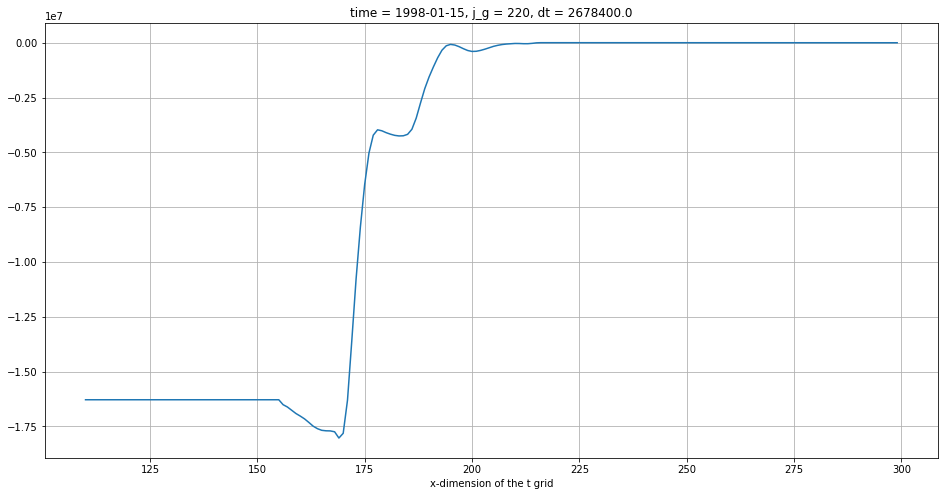

In [63]:
volume_over_i[72, :].plot(figsize=(16,8))
pltt.grid(True)

In [19]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
l_i = grid.interp(coords.XC, axis = 'Y')
long_interp = l_i[220, :]
istar2 = long_interp[istar1]
istar2.load()

<xarray.DataArray 'mul-0e1c2e166110eff2d573c968fb5d0132' (time: 288)>
array([-107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5,
       -107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5,
       -107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5,  -30.5,
        -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -31.5,
        -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -32.5,  -31.5,
        -32.5,  -32.5,  -31.5,  -31.5,  -32.5,  -32.5,  -31.5,  -31.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -27.5,  -27.5,  -27.5,  -27.5,  -27.5,
        -27.5,  -26.5,  -26.5,  -27.5,  -27.5,  -27.5,  -27.5,  -27.5,
        -27.5,  -27.5,  -27.5,  -27.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -27.5,
        -27.5,  -27.5,  -27.5,  -27.5,  -27.5,  -27.5,  -26.5,  -27.5,
        -27.5,  -26.5,  -26.5,  -26.5,  -26.5,  -25.5,  -25.5,  -24.5,
        -25.5,  -25.5,  -25.5,  -26.5,  -26.5,  -27.5,  -26.5,  -27.5,
        -27.5,  -27.5,  -27.5,  -27.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -30.5,  -29.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -30.5,  -30.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5],
      dtype=float32)
Coordinates:
    j_g      int64 220
    i        (time) int64 110 110 110 110 110 110 ... 187 187 187 187 187 187
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [20]:
istar3 = istar1+1 
volume_at_istar = tr.where(tr.i < istar1).sum('i')

#Interpolation
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


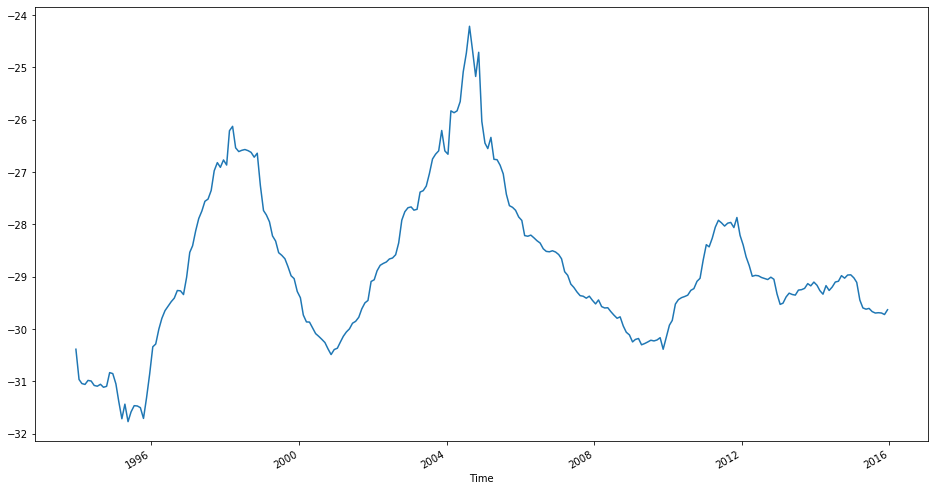

In [21]:
smooth_longitude =  ratio + istar2
smooth_longitude.plot(figsize=(16,8))